In [77]:

!pip install tensorflow-gpu

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

2022-04-13 10:30:52.569939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 10:30:52.569994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6dae9ddd-bc2f-460f-8a76-d6706e4c17cf;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 in central
:: resolution report :: resolve 253ms :: artifacts dl 4ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrie

In [79]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [80]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [81]:
df = df.sort_values('Date')

In [82]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [1]:
df.shape

NameError: name 'df' is not defined

Text(0, 0.5, 'Close Price (USD)')

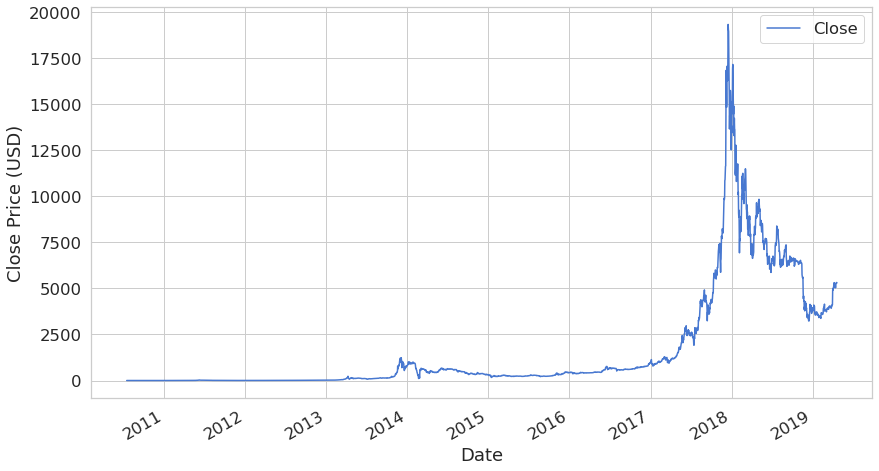

In [84]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [85]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [86]:
scaled_close.shape

(3201, 1)

In [87]:
np.isnan(scaled_close).any()

False

In [88]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [89]:
scaled_close = scaled_close.reshape(-1, 1)

In [90]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [91]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [92]:
X_train.shape

(2945, 99, 1)

In [93]:
X_test.shape

(156, 99, 1)

# Model

In [94]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

In [95]:


model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [96]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
42/42 [==============================] - 104s 2s/step - loss: 0.0020 - val_loss: 0.0061
Epoch 2/50
42/42 [==============================] - 58s 1s/step - loss: 0.0102 - val_loss: 0.0056
Epoch 3/50
42/42 [==============================] - 57s 1s/step - loss: 0.0043 - val_loss: 0.0356
Epoch 4/50
42/42 [==============================] - 57s 1s/step - loss: 0.0070 - val_loss: 0.0353
Epoch 5/50
42/42 [==============================] - 58s 1s/step - loss: 0.0142 - val_loss: 0.0742
Epoch 6/50
42/42 [==============================] - 58s 1s/step - loss: 0.0101 - val_loss: 0.0113
Epoch 7/50
42/42 [==============================] - 62s 1s/step - loss: 0.0070 - val_loss: 0.0313
Epoch 8/50
42/42 [==============================] - 60s 1s/step - loss: 0.0121 - val_loss: 0.0572
Epoch 9/50
42/42 [==============================] - 57s 1s/step - loss: 0.0121 - val_loss: 0.0377
Epoch 10/50
42/42 [==============================] - 57s 1s/step - loss: 0.0039 - val_loss: 0.0012
Epoch 11/50
42/42 

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 151ms/step - loss: 0.0018


0.0017723538912832737

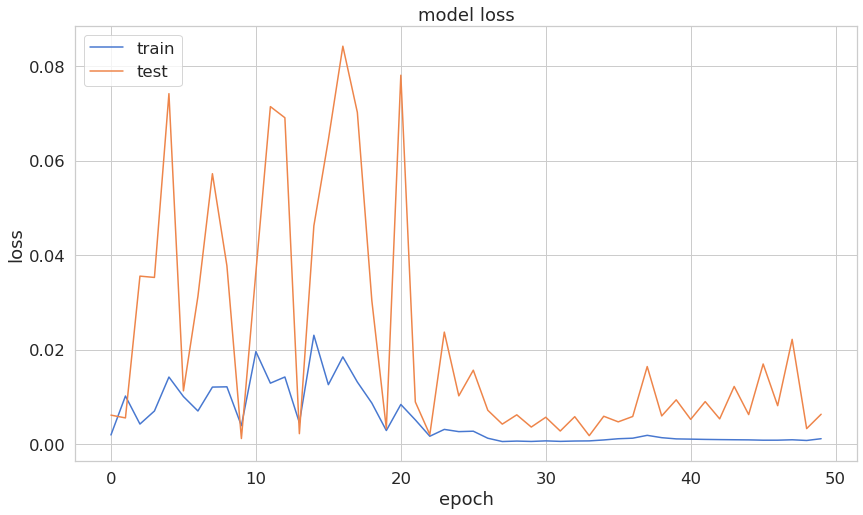

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

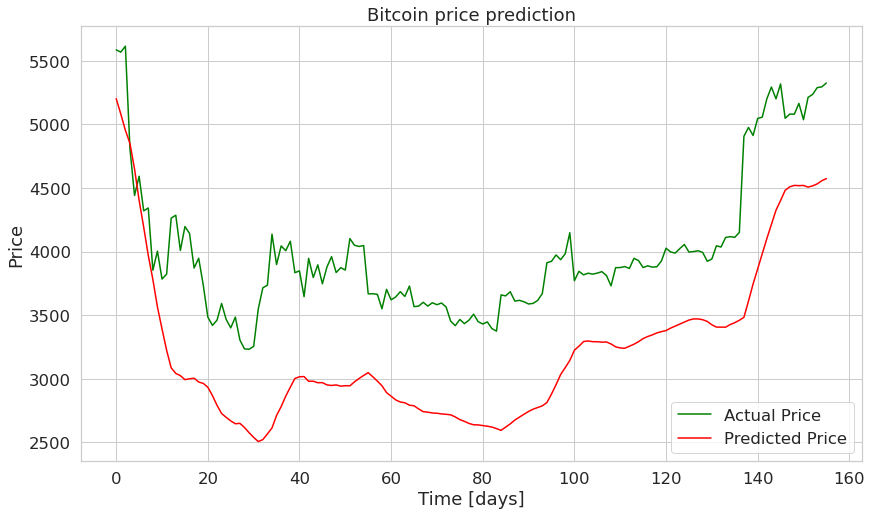

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();